In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

## Figure 6: Statistical error

In [2]:
path_result = 'results/ex1/'
p = 1000
df = pd.DataFrame()
for sigma in [0.8, 1.]:
    for n in [100,200,300,400]:
        _df = pd.read_csv('{}res_{}_{}_sigma_{:.01f}.csv'.format(path_result, n, p, sigma))
        _df['sigma'] = sigma
        df = pd.concat([df, _df])

df =df.reset_index(drop=True)
df['type'] = df['method'] + df['has_U'].apply(lambda x: 'U' if x else '')

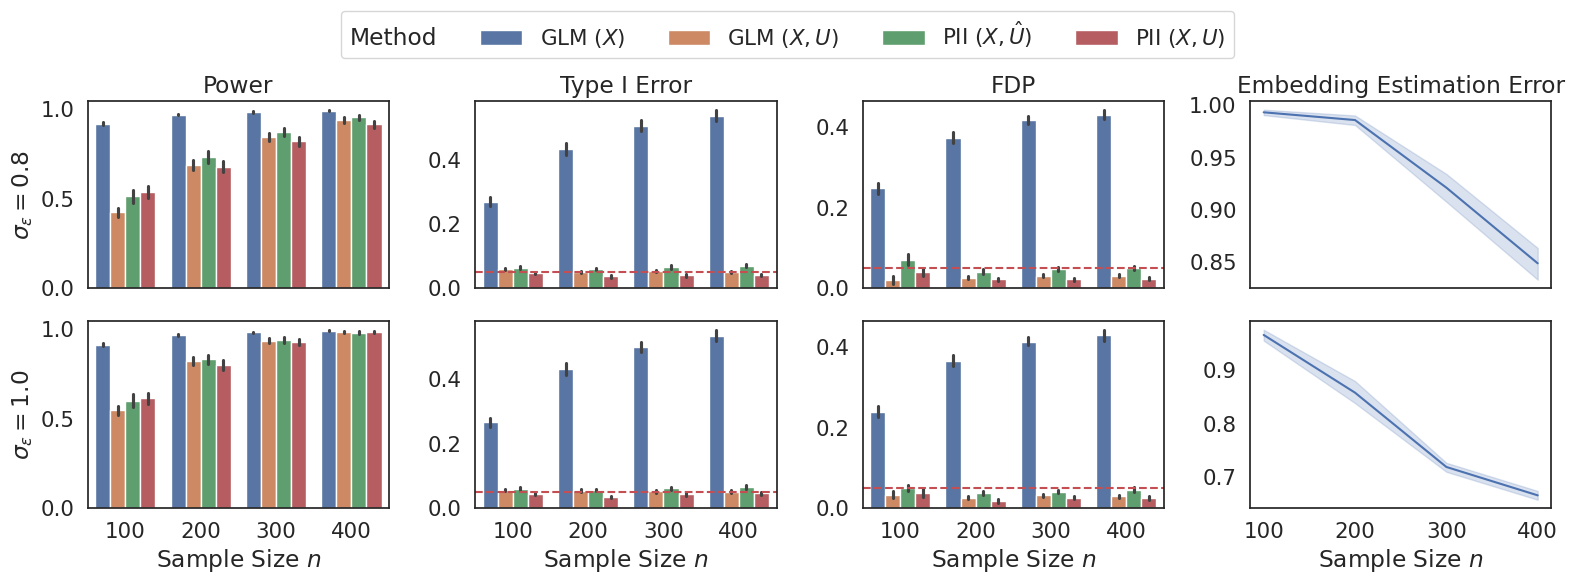

In [3]:
sns.set(font_scale=1.4, style = "white")
fig, axes = plt.subplots(2,4,figsize=(16,6), sharex='col')

for i, sigma in enumerate([0.8, 1.]):
    _df = df[df['sigma'] == sigma]
    sns.barplot(data=_df, x='n', y='power', hue='type', ax=axes[i,0])
    sns.barplot(data=_df, x='n', y='type1_err', hue='type', ax=axes[i,1])
    sns.barplot(data=_df, x='n', y='fdr_BH', hue='type', ax=axes[i,2])
    axes[i,1].axhline(0.05, color='r', linestyle='--')
    axes[i,2].axhline(0.05, color='r', linestyle='--')

    sns.lineplot(data=_df[~np.isnan(_df['err_U'])], x='n', y='err_U', ax=axes[i,3])

    axes[i,0].set_ylabel(r'$\sigma_{{\epsilon}}={:.01f}$'.format(sigma))
    for j in range(1,4):
        axes[i,j].set_ylabel('')

for j, title in enumerate(['Power', 'Type I Error', 'FDP', 'Embedding Estimation Error']):
    axes[0,j].set_title(title)
    axes[1,j].set_title('')

for j in range(4):
    axes[1,j].set_xlabel('Sample Size $n$')

lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,1]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
labels = ['GLM ($X$)', 'GLM ($X, U$)', r'PII ($X, \hat{U}$)', 'PII ($X, U$)']

legend = fig.legend(handles=handles, labels=labels, loc=9, ncol=4, title='Method')

for i in range(2):
    for j in range(3):
        axes[i,j].get_legend().remove()

legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.83)
plt.savefig('results/ex1_sigma.pdf', bbox_inches='tight', dpi=300)

## Figure F1: Convergence rate

In [4]:
path_result = 'results/ex3/'
p = 1000;
sigma_list = [0.8,1.]
ns = [100,150,200,300]
df = pd.DataFrame()
for sigma in sigma_list:
    for n in ns:
        _df = pd.read_csv('{}res_{}_{}_sigma_{:.01f}.csv'.format(path_result, n, p, sigma))
        _df['sigma'] = sigma
        df = pd.concat([df, _df])
df['mse_X'] = df['mse_X'].where(df['mse_X'] > 0, 1e-6)
df['mse_X'] = df['mse_X'].where(df['mse_X'] > 1e-6, 1e-2)


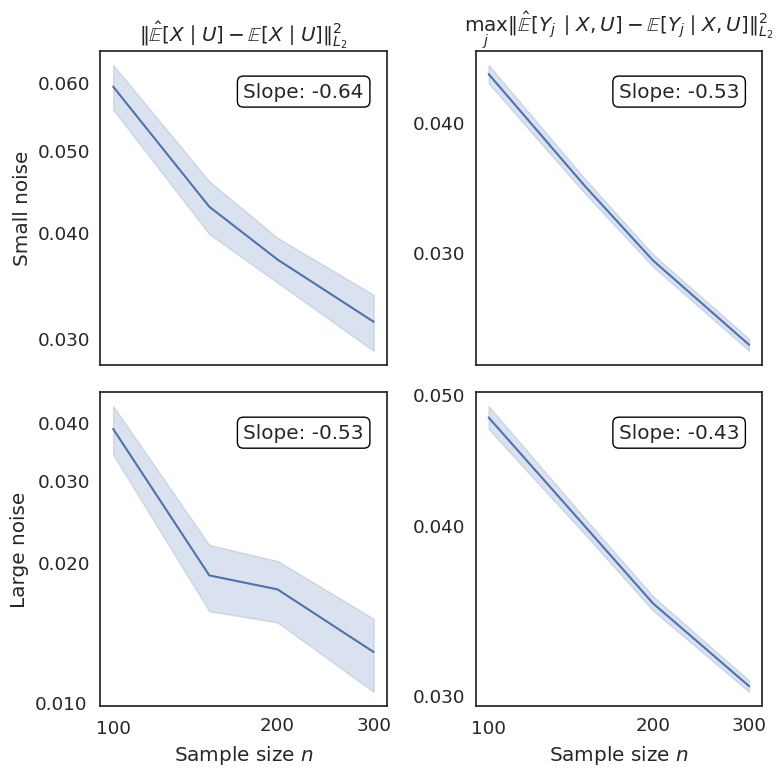

In [5]:
title_list = [r'$\|\hat{\mathbb{E}}[X\mid U] - \mathbb{E}[X\mid U]\|_{L_2}^2$', r'$\max_j\|\hat{\mathbb{E}}[Y_j\mid X,U]-\mathbb{E}[Y_j\mid X,U]\|_{L_2}^2$']
ylabel_list = ['Small noise', 'Large noise']

sns.set(font_scale=1.2, style='white')
fig, axes = plt.subplots(2,2,figsize=(8,8), sharex=True)
for i, sigma in enumerate(sigma_list):
    for j, name in enumerate(['mse_X', 'mse_Y']):
        filtered_data = df[(df['sigma']==sigma) & (df['has_U']==1) & ~np.isnan(df[name])]
        
        # Compute the slope using linear regression
        X = np.log10(filtered_data[['n']].values)
        y = np.log10(filtered_data[name].values)
        reg = LinearRegression().fit(X, y)
        slope = reg.coef_[0]
        
        sns.lineplot(data=filtered_data, x='n', y=name, ax=axes[i,j], estimator='median', errorbar='se')       

        axes[i,j].text(0.5, 0.9, f'Slope: {slope:.2f}', transform=axes[i,j].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

        axes[i,j].set_xticks(ns)
        axes[i,j].set_xscale('log')
        axes[i,j].set_yscale('log')
        
        axes[i,j].xaxis.set_major_formatter(ScalarFormatter())
        axes[i,j].xaxis.set_minor_formatter(ScalarFormatter())

        axes[i,j].yaxis.set_major_formatter(ScalarFormatter())
        axes[i,j].yaxis.set_minor_formatter(ScalarFormatter())

        if j==0:
            axes[i,j].set_ylabel(ylabel_list[i])
        else:
            axes[i,j].set_ylabel('')        

        if i >0:
            axes[i,j].set_xlabel('Sample size $n$')
            axes[i,j].set_title('')
        else:
            axes[i,j].set_xlabel('')
            axes[i,j].set_title(title_list[j])

fig.tight_layout()
plt.savefig('results/ex2_conv.pdf', bbox_inches='tight', dpi=300)